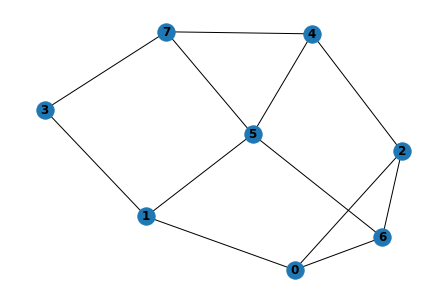

In [4]:
# 导入相关依赖
from mindquantum.core import Circuit, Hamiltonian, UN, H, ZZ, RX, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import networkx as nx
import mindspore.nn as nn

# 搭建所需求解的图
g = nx.Graph()
nx.add_path(g, [0, 1])
nx.add_path(g, [0, 2])
nx.add_path(g, [1, 3])
nx.add_path(g, [2, 4])
nx.add_path(g, [4, 5])
nx.add_path(g, [4, 7])
nx.add_path(g, [5, 6])
nx.add_path(g, [6, 2])
nx.add_path(g, [7, 4])
nx.add_path(g, [1, 5])
nx.add_path(g, [0, 6])
nx.add_path(g, [5, 7])
nx.add_path(g, [7, 3])
nx.draw(g, with_labels=True, font_weight='bold')

In [3]:
# 用穷举法来看看所有情况的切割边数。
for i in g.nodes:
    print('one size:', [i], 'cut=', nx.cut_size(g, [i]))            # 一组1个节点、另一组4个节点的所有情况
    for j in range(i):
        print('one size:', [i, j], 'cut=', nx.cut_size(g, [i, j]))  # 一组2个节点、另一组3个节点的所有情况

one size: [0] cut= 3
one size: [1] cut= 3
one size: [1, 0] cut= 4
one size: [2] cut= 3
one size: [2, 0] cut= 4
one size: [2, 1] cut= 6
one size: [3] cut= 2
one size: [3, 0] cut= 5
one size: [3, 1] cut= 3
one size: [3, 2] cut= 5
one size: [4] cut= 3
one size: [4, 0] cut= 6
one size: [4, 1] cut= 6
one size: [4, 2] cut= 4
one size: [4, 3] cut= 5
one size: [5] cut= 4
one size: [5, 0] cut= 7
one size: [5, 1] cut= 5
one size: [5, 2] cut= 7
one size: [5, 3] cut= 6
one size: [5, 4] cut= 5
one size: [7] cut= 3
one size: [7, 0] cut= 6
one size: [7, 1] cut= 6
one size: [7, 2] cut= 6
one size: [7, 3] cut= 3
one size: [7, 4] cut= 4
one size: [7, 5] cut= 5
one size: [7, 6] cut= 6
one size: [6] cut= 3
one size: [6, 0] cut= 4
one size: [6, 1] cut= 6
one size: [6, 2] cut= 4
one size: [6, 3] cut= 5
one size: [6, 4] cut= 6
one size: [6, 5] cut= 5


In [6]:
# 搭建QAOA量子线路，其中ansatz线路包含可以训练的参数
# 搭建UC(γ)对应的量子线路：
def build_hc(g, para):
    hc = Circuit()
    for i in g.edges:
        hc += ZZ(para).on(i)
    hc.barrier()
    return hc
    
# 搭建UB(β)对应的量子线路：
def build_hb(g, para):
    hb = Circuit()
    for i in g.nodes:
        hb += RX(para).on(i)
    hb.barrier()
    return hb

# 搭建多层的训练网络：
def build_ansatz(g, p):                    
    circ = Circuit()
    for i in range(p):
        circ += build_hc(g, f'g{i}')
        circ += build_hb(g, f'b{i}')
    return circ

# 构建图对应的哈密顿量
def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')
    return ham

circuit = build_hc(g, 'gamma')
circuit.svg()

circuit = build_hb(g, 'beta')
circuit.svg()

# 实现了一层酉变换UB(β)UC(γ)的ansatz线路
circuit = build_hc(g, 'gamma') + build_hb(g, 'beta')
circuit.svg()

In [9]:
# 生成完整的量子线路和图所对应的哈密顿量
p = 4
ham = Hamiltonian(build_ham(g))
init_state_circ = UN(H, g.nodes)
ansatz = build_ansatz(g, p)
circ = init_state_circ + ansatz
circ.svg()


In [12]:
# 搭建待训练量子神经网络
import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

sim = Simulator('projectq', circ.n_qubits)                     # 创建模拟器，backend使用‘projectq’，能模拟5个比特（'circ'线路中包含的比特数）
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
net = MQAnsatzOnlyLayer(grad_ops)                              # 生成待训练的神经网络
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net = nn.TrainOneStepCell(net, opti)                     # 对神经网络进行一步训练

# 训练并展示结果
for i in range(200):
    cut = (len(g.edges) - train_net()) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
    if i%10 == 0:
        print("train step:", i, ", cut:", cut)  # 每训练10步，打印当前训练步数和当前得到的切割边数

train step: 0 , cut: [6.000305]
train step: 10 , cut: [8.033105]
train step: 20 , cut: [9.016346]
train step: 30 , cut: [9.375294]
train step: 40 , cut: [9.449112]
train step: 50 , cut: [9.523526]
train step: 60 , cut: [9.537504]
train step: 70 , cut: [9.541277]
train step: 80 , cut: [9.544347]
train step: 90 , cut: [9.544895]
train step: 100 , cut: [9.5449915]
train step: 110 , cut: [9.545166]
train step: 120 , cut: [9.545186]
train step: 130 , cut: [9.545204]
train step: 140 , cut: [9.545206]
train step: 150 , cut: [9.545207]
train step: 160 , cut: [9.545208]
train step: 170 , cut: [9.545208]
train step: 180 , cut: [9.545208]
train step: 190 , cut: [9.545208]


In [13]:
# 获取最优参数
pr = dict(zip(ansatz.params_name, net.weight.asnumpy())) # 获取线路参数
print(pr)

{'g0': -0.17906626, 'b0': 1.1259668, 'g1': -0.3577976, 'b1': 0.858607, 'g2': -0.4288441, 'b2': 0.6286725, 'g3': -0.4833493, 'b3': 0.31985766}


In [14]:
# 画出最终量子态在计算基矢下的概率分布
circ.measure_all()                               # 为线路中所有比特添加测量门
sim.sampling(circ, pr=pr, shots=1000).svg()      # 运行线路1000次并打印结果